In [6]:
import sys
sys.path.insert(0, "C:/Users/User/Documents/PhD/PrintedTrees")

In [23]:
import pandas as pd
import numpy as np
from sklearn import tree
from functools import partial
from src import ALL_DATASETS, ALL_ACCURACY_METRICS, project_dir
from src.datasets import get_data
from src.utils import logging_cfg, get_area_lut, get_candidates
from src.nsga2.objectives import calc_fitness, null_objective_function
from src.nsga2.problem import Problem
from src.nsga2.evolution import Evolution
import argparse
import logging
import traceback

In [10]:
dataset = 'seeds'
input_bits = 4

In [25]:
classifier = tree.DecisionTreeClassifier()
x_train, x_test, y_train, y_test = get_data(dataset, input_bits=input_bits)
print(f"Training data: x {x_train.shape}, y {y_train.shape}")
print(f"Test data: x {x_test.shape}, y {y_test.shape}")
classifier.fit(x_train,y_train)

Training data: x (147, 8), y (147,)
Test data: x (63, 8), y (63,)


DecisionTreeClassifier()

In [28]:
n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 7] <= 0.75 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 7] <= 0.25 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a leaf node.


In [34]:
thresholds = classifier.tree_.threshold
print(f"Thresholds: {type(thresholds)}{thresholds}")
print(f"Nodes: {classifier.tree_.node_count}")
print(f"Children left: {classifier.tree_.children_left}")
print(f"Children right: {classifier.tree_.children_right}")
print(f"Feature separator: {classifier.tree_.feature}")
print(f"Number of samples: {classifier.tree_.n_node_samples}")
print(f"Impurity: {classifier.tree_.impurity}")

Thresholds: <class 'numpy.ndarray'>[0. 1. 2. 3. 4.]
Nodes: 5
Children left: [ 1  2 -1 -1 -1]
Children right: [ 4  3 -1 -1 -1]
Feature separator: [ 7  7 -2 -2 -2]
Number of samples: [147  94  44  50  53]
Impurity: [0.66472303 0.49796288 0.         0.         0.        ]


[Text(200.88000000000002, 181.2, 'X[7] <= 0.75\ngini = 0.665\nsamples = 147\nvalue = [44, 50, 53]'),
 Text(133.92000000000002, 108.72, 'X[7] <= 0.25\ngini = 0.498\nsamples = 94\nvalue = [44, 50, 0]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 44\nvalue = [44, 0, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 50\nvalue = [0, 50, 0]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 53\nvalue = [0, 0, 53]')]

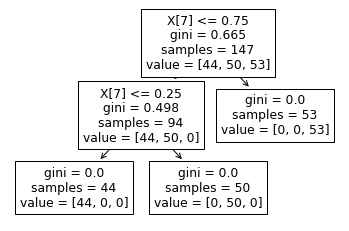

In [30]:
tree.plot_tree(classifier)

In [32]:
classifier.tree_.threshold[0] = 0  # list(range(5))

In [33]:
for i in range(5):
    classifier.tree_.threshold[i] = i
classifier.tree_.threshold

array([0., 1., 2., 3., 4.])